In [7]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle
from IPython.display import SVG
import cvzone
import time
import supervision as sv
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
%matplotlib inline

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
batch_size = 32
num_epochs = 20
lr = 0.005

In [9]:
class FolderDataset(Dataset):
    def __init__(self, root_dir, samples, transform=None):
        self.samples = samples
        self.transform = transform
        label_map = {}

        for idx, label_folder in enumerate(sorted(os.listdir(root_dir))):
            label_path = os.path.join(root_dir, label_folder)
            if os.path.isdir(label_path):
                label_map[label_folder] = idx
                for filename in os.listdir(label_path):
                    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                        full_path = os.path.join(label_path, filename)
                        samples.append((full_path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # [H,W,C] → [C,H,W]
        return torch.tensor(img), torch.tensor(label, dtype=torch.long)

In [10]:
# ----- Mô hình CNN -----
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5) 
        self.fc1 = nn.Linear(16 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [11]:
train_dataset = FolderDataset(r"C:\VSCode\Python\face_recognition\dataset\train", [])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# # ----- Huấn luyện -----
# model = ClassificationCNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     avg_loss = running_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 2.5205
Epoch [2/20], Loss: 1.6171
Epoch [3/20], Loss: 1.5900
Epoch [4/20], Loss: 1.5230
Epoch [5/20], Loss: 1.4187
Epoch [6/20], Loss: 1.2972
Epoch [7/20], Loss: 1.1835
Epoch [8/20], Loss: 1.0704
Epoch [9/20], Loss: 0.8875
Epoch [10/20], Loss: 0.7522
Epoch [11/20], Loss: 0.8138
Epoch [12/20], Loss: 0.7458
Epoch [13/20], Loss: 0.5713
Epoch [14/20], Loss: 0.4133
Epoch [15/20], Loss: 0.3665
Epoch [16/20], Loss: 0.3825
Epoch [17/20], Loss: 0.5150
Epoch [18/20], Loss: 0.3520
Epoch [19/20], Loss: 0.2437
Epoch [20/20], Loss: 0.2067


In [ ]:
# ----- Lưu mô hình -----
# torch.save(model.state_dict(), r"C:\VSCode\Python\face_recognition\classification.pth")

In [13]:
# ----- Hàm hiển thị ảnh -----
def show_image(img, title=""):
    if img.ndim == 3 and img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    if img.dtype in [np.float32, np.float64] and img.max() > 1.0:
        img = img / 255.0
    plt.imshow(img[..., ::-1])
    plt.title(title)
    plt.axis("off")
    plt.show()

In [21]:
def predict_image(image_input, model, class_names, img_size=224):

    if isinstance(image_input, str):
        img = cv2.imread(image_input, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Không thể đọc ảnh từ đường dẫn: {image_input}")
        image_name = os.path.basename(image_input)
    elif isinstance(image_input, np.ndarray):
        img = image_input
        image_name = "image_cropped"
    else:
        raise TypeError("Error input")

    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)
    tensor = torch.tensor(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probs, dim=1)
        confidence = confidence.item()
        predicted_class = predicted_class.item()

    if confidence < 0.5:
        pred_label = "unknown"
    else:
        pred_label = class_names[predicted_class]

    print(f"Ảnh: {os.path.basename(image_name)}")
    print(f"Dự đoán: {pred_label} (độ tin cậy: {confidence * 100:.2f}%)")

    show_image(np.transpose(img, (1, 2, 0)), f"{pred_label} ({confidence*100:.1f}%)")


Ảnh: scarlett_johansson19.png
Dự đoán: scarlett_johansson (độ tin cậy: 99.92%)


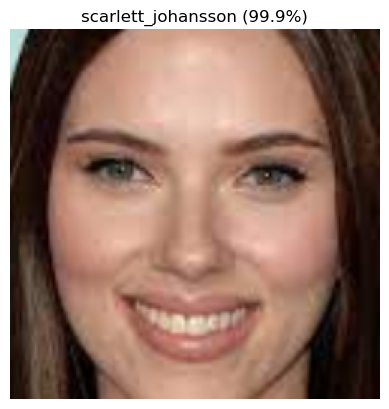

In [22]:
# ----- Dự đoán thử -----
model = ClassificationCNN()
model.load_state_dict(torch.load(r"C:\VSCode\Python\face_recognition\classification.pth", 
                                 map_location=device))
model.to(device)

class_names = ['chris_evans', 
               'chris_hemsworth', 
               'mark_ruffalo', 
               'robert_downey_jr', 
               'scarlett_johansson']

predict_image(r"C:\VSCode\Python\face_recognition\dataset\test\scarlett_johansson\scarlett_johansson19.png", 
              model, 
              class_names)

0: 512x960 1 face, 2782.3ms
Speed: 90.5ms preprocess, 2782.3ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 960)
Ảnh: image_cropped
Dự đoán: chris_evans (độ tin cậy: 67.91%)


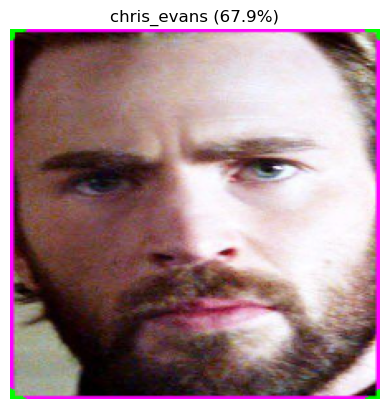

In [36]:
import cropped

face = cropped.crop_face(r'C:\VSCode\Python\face_recognition\test_3.jpg')

predict_image(face, model, class_names)
